<a href="https://colab.research.google.com/github/FabrizioCabreraC/Hollywood-as-recession-proof/blob/main/Hollywood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#%pip install cpi
%matplotlib inline
#%pip install scrapy
#import scrapy
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API

To try and answer the question of how recession proof the film in industry is we collected data from three different sources. 

Economic data was from the Federal Reserve Economic Database through the use of the FRED API. More specifically the fredapi package was used with a custom built funtion to pull individal series. This data includes, (but may not be linited to in the final draft) real GDP, CPI, Unemployment Rate, Consumer Confidence, real GDP per capita, and the Fed Funds Rate. The time series collected for these indicator varies, but was restructed to either show monthy (if available), or quarterly data. As of this moment all the variables were merged to start in 1990, as this is when gas price was first measured, but the data many be concatinated to allow a deeper range of years for the variables that have more data. 

Box office data was pulled from the monthly domestic box office tables on the website BoxOffice Mojo through read.html. This data was also modfied to show quarelty sums of total box office revneue and total films released. The quartely data was then merged into the data_qrt dataframe with the economic indicators.

In order to obtain the average review ratings of movies released each year further film data was taken from links to the IMDB database.  More specifcially the title.basics.tsv.gz and the title.ratings.tsv.gz tables from the IMDB data sets. These two data sets have been merged together to provide the yearly average review scores for all movies released. It has not yet been merged into the data.qrt table as it can only be measured buy the year, and we are now unsure if it will need to be used in the final project. 

Visualizations to be displayed will include charts showing the relationship between certain macroeconomic indicators and the supply and demand of the film industry since the 1980s. For instance, the charts will display a time series analysis that shows the state of the economy during those years. Thus, it will be observable how well the box office did during the recessions. Then, we would evaluate what happened in the cinema entertainment with respect to each variable: GDP, CPI, Unemployment Rate, Consumer Confidence, GDP per capita, the Fed Funds Rate. The charts will not only show the box office performance, but they will also display the market share movements related to the film industry during the pertinent period. In such a way, it will be seen whether Hollywood was affected by recessions and/or other non-economic factors, and by how much.

Section 1: Pulls desired economic data series from FRED API

In [2]:
fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") 
# my API Key, careful with it I guess.
# this is a fucntion the uses fredapi packages to easily retrive series

In [3]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of a series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data sereis complied on FRED website 
    
    returns:
    --------
    dataframe: a dataframe of the FRED metric according to the data series
    given to the function
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da")
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"}
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

Below use the get_fred fucntion to obatin the desiresed series that will be cleaned and put into a data set.

In [4]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp
GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP
consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent
debt_income = get_fred("TDSP") #total debt service to income ratio, by quater
#debt_income
gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita
gas_prices = get_fred("GASREGCOVW") #national gas price average, by week
#gas_prices
inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year
#inflation
PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more legible and useable.

In [5]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

In [6]:
p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

In [7]:
i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

In [8]:
gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

In [9]:
jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

In [10]:
debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

In [11]:
Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

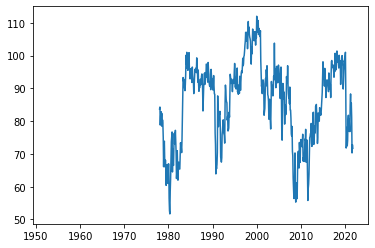

In [12]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [13]:
data_month = gas_prices.merge(
    unemp.merge(
    consumer_sent, on="Date", how="outer"))
#data_month.head(10)

In [14]:
# Pulling in Data From Box Office Mojo

In [15]:
data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

In [16]:
data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head(10)


In [17]:
def get_table(url):
    '''
    Function gets the datatable requesuted from the boxoffice mojo
    url and outputs to a dataframe
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [18]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)
#box_year

In [19]:
box_jan = get_table("https://www.boxofficemojo.com/month/january/?grossesOption=calendarGrosses")
box_feb = get_table("https://www.boxofficemojo.com/month/february/?grossesOption=calendarGrosses")
box_mar = get_table("https://www.boxofficemojo.com/month/march/?grossesOption=calendarGrosses")
box_apr = get_table("https://www.boxofficemojo.com/month/april/?grossesOption=calendarGrosses")
box_may = get_table("https://www.boxofficemojo.com/month/may/?grossesOption=calendarGrosses")
box_jun = get_table("https://www.boxofficemojo.com/month/june/?grossesOption=calendarGrosses")
box_jul = get_table("https://www.boxofficemojo.com/month/july/?grossesOption=calendarGrosses")
box_aug = get_table("https://www.boxofficemojo.com/month/august/?grossesOption=calendarGrosses")
box_sep = get_table("https://www.boxofficemojo.com/month/september/?grossesOption=calendarGrosses")
box_oct = get_table("https://www.boxofficemojo.com/month/october/?grossesOption=calendarGrosses")
box_nov = get_table("https://www.boxofficemojo.com/month/november/?grossesOption=calendarGrosses")
box_dec = get_table("https://www.boxofficemojo.com/month/december/?grossesOption=calendarGrosses")

In [20]:
#box_feb

In [21]:
def reduce_table(df, month: int):
    jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    'Genre', 'Budget', 'Running Time'], axis=1)
    jeff["month"] = month
    jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    return jeff

In [22]:
box_jan = reduce_table(box_jan,1)
box_feb = reduce_table(box_feb,2)
box_mar = reduce_table(box_mar,3)
box_apr = reduce_table(box_apr,4)
box_may = reduce_table(box_may,5)
box_jun = reduce_table(box_jun,6)
box_jul = reduce_table(box_jul,7)
box_aug = reduce_table(box_aug,8)
box_sep = reduce_table(box_sep,9)
box_oct = reduce_table(box_oct,10)
box_nov = reduce_table(box_nov,11)
box_dec = reduce_table(box_dec,12)

In [23]:
box_office = (pd.concat([box_jan,box_feb,box_mar,box_apr,box_may,box_jun,
                        box_jul,box_aug,box_sep, box_oct, box_nov, box_dec],
                       axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office["gross"] = (box_office["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_month = box_office.copy()
box_office_month.head()

,Cumulative Gross,Releases,Average,gross
Date,,,,
1972-03-01,"$133,698,921",1,"$133,698,921",133698921
1972-12-01,"$84,563,118",1,"$84,563,118",84563118
1975-06-01,"$23,565,886",1,"$23,565,886",23565886
1975-07-01,"$46,159,490",1,"$46,159,490",46159490
1975-11-01,"$190,274,624",1,"$190,274,624",190274624


In [24]:
box_office_qrt = box_office.resample("QS").sum()
box_office_qrt = box_office_qrt.reset_index()

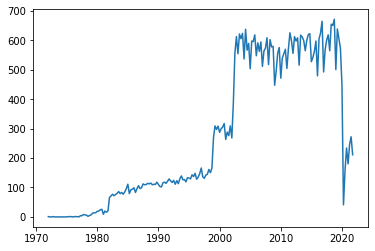

In [25]:
plt.plot(box_office_qrt.Date,box_office_qrt.Releases)

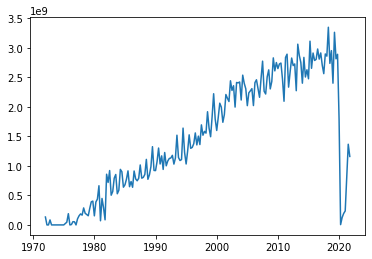

In [26]:
plt.plot(box_office_qrt.Date,box_office_qrt.gross)

In [27]:
data_qrt = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_qrt["PCE"] = data_qrt["PCE"] * .01
data_qrt["gas_price"] = data_qrt["gas_price"]/data_qrt["PCE"]
data_qrt["gross"] = data_qrt["gross"]/data_qrt["PCE"]
data_qrt.head()

,Date,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
0,1990-01-01,NaN,5.300000,91.266667,9364.259,37617.0,0.62198,11.649150,110,1.479302e+09
1,1990-04-01,NaN,5.333333,90.933333,9398.243,37636.0,0.62764,11.600660,103,1.709974e+09
2,1990-07-01,1.947705,5.700000,79.133333,9404.494,37529.0,0.63562,11.583131,102,2.047944e+09
3,1990-10-01,2.070536,6.133333,65.133333,9318.876,37056.0,0.64402,11.604449,116,1.602071e+09
4,1991-01-01,1.706441,6.600000,74.966667,9275.276,36769.0,0.64740,11.578032,118,1.806037e+09


In [28]:
# original data cleaning

In [29]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t')

In [31]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [32]:
df=pd.DataFrame(df)
print(df["titleType"].unique())
df = df.query("titleType == 'movie' & isAdult == 0")

['short' 'movie' 'tvEpisode' 'tvSeries' 'tvShort' 'tvMovie' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'tvPilot']


In [33]:
# Fab: I run to see the different variety of genres and see what can we do with them
df.T.apply(lambda x: x.nunique(), axis=1)

tconst            583826
titleType              1
primaryTitle      506421
originalTitle     517107
isAdult                1
startYear            223
endYear                1
runtimeMinutes       486
genres              1376
dtype: int64

In [34]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama


In [35]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1841
1,tt0000002,6.0,236
2,tt0000003,6.5,1603
3,tt0000004,6.0,153
4,tt0000005,6.2,2422


In [36]:
movies = df[["tconst","startYear",]]
movies.head()

,tconst,startYear
498,tt0000502,1905
570,tt0000574,1906
587,tt0000591,1907
610,tt0000615,1907
625,tt0000630,1908


In [37]:
movies["startYear"].unique()

array([1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911, 1913, 1915, 1914,
       1919, 1916, 1917, 1936, 1925, 1918, 1920, 1922, 1921, 2019, 1924,
       1923, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014, 1930, 1942,
       1932, 1931, 1934, 1939, 1937, 1933, 1950, 1938, 1951, 1946, 1996,
       1940, 1944, 1947, 1941, 1952, 1970, 1957, 1943, 1948, 1945, 2001,
       1949, 1953, 2008, 1954, 1965, 1983, 1980, 1973, 1961, 1955, 1962,
       1958, 1956, 1977, 1964, 1967, 1960, 1959, 1968, 1963, 1971, 1969,
       1972, 1966, 1976, 1990, 1979, 1981, 2020, 1975, 1978, 1989, 1974,
       1986, '1971', '1972', '1970', '1974', '1973', '1976', '1969',
       '1981', '1968', '1985', '1986', '1987', '1975', '1965', '1978',
       '1967', '1990', '2018', '1977', '1979', '1984', '1966', '1988',
       '1982', '\\N', '1980', '1983', '1991', '1963', '2001', '1961',
       '1989', '1994', '1993', '1964', '1957', '2019', '1992', '2017',
       '2005', '1953', '2004', '1998', '2020', '1947', '1995', '

In [38]:
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["startYear"].unique()

array([1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911, 1913, 1915, 1914,
       1919, 1916, 1917, 1936, 1925, 1918, 1920, 1922, 1921, 2019, 1924,
       1923, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014, 1930, 1942,
       1932, 1931, 1934, 1939, 1937, 1933, 1950, 1938, 1951, 1946, 1996,
       1940, 1944, 1947, 1941, 1952, 1970, 1957, 1943, 1948, 1945, 2001,
       1949, 1953, 2008, 1954, 1965, 1983, 1980, 1973, 1961, 1955, 1962,
       1958, 1956, 1977, 1964, 1967, 1960, 1959, 1968, 1963, 1971, 1969,
       1972, 1966, 1976, 1990, 1979, 1981, 2020, 1975, 1978, 1989, 1974,
       1986, '1971', '1972', '1970', '1974', '1973', '1976', '1969',
       '1981', '1968', '1985', '1986', '1987', '1975', '1965', '1978',
       '1967', '1990', '2018', '1977', '1979', '1984', '1966', '1988',
       '1982', '1980', '1983', '1991', '1963', '2001', '1961', '1989',
       '1994', '1993', '1964', '1957', '2019', '1992', '2017', '2005',
       '1953', '2004', '1998', '2020', '1947', '1995', '2002', 

In [39]:
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before

In [40]:
movies = movies.set_index("startYear")
movies

,tconst
startYear,
1905-01-01,tt0000502
1906-01-01,tt0000574
1907-01-01,tt0000591
1907-01-01,tt0000615
1908-01-01,tt0000630
...,...
2015-01-01,tt9916622
2007-01-01,tt9916680
2013-01-01,tt9916706


In [41]:
movies = movies.loc["1980":"2019"]

In [42]:
movies = movies.reset_index()
movies

,startYear,tconst
0,2019-01-01,tt0011216
1,2019-01-01,tt0011801
2,2000-01-01,tt0015414
3,1993-01-01,tt0015724
4,2014-01-01,tt0016906
...,...,...
312762,2015-01-01,tt9916622
312763,2007-01-01,tt9916680
312764,2013-01-01,tt9916706
312765,2017-01-01,tt9916730


In [43]:
#movies = movies.loc[movies["desired"] == True]
#movies

In [44]:
movies["startYear"].unique()

array(['2019-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '2002-01-01

In [45]:
print(movies.dtypes)
movies.head()

startYear    datetime64[ns]
tconst               object
dtype: object


,startYear,tconst
0,2019-01-01,tt0011216
1,2019-01-01,tt0011801
2,2000-01-01,tt0015414
3,1993-01-01,tt0015724
4,2014-01-01,tt0016906


In [46]:
rated = pd.merge(movies[["tconst","startYear"]], df_ratings, on="tconst", how="inner")
rated.info

<bound method DataFrame.info of            tconst  startYear  averageRating  numVotes
0       tt0011216 2019-01-01            6.9        29
1       tt0015414 2000-01-01            5.3        15
2       tt0015724 1993-01-01            6.2        25
3       tt0016906 2014-01-01            5.6        19
4       tt0025541 1996-01-01            7.5        21
...           ...        ...            ...       ...
181862  tt9916132 2018-01-01            4.0         7
181863  tt9916160 2019-01-01            6.4        48
181864  tt9916170 2019-01-01            7.2         5
181865  tt9916428 2019-01-01            3.8        14
181866  tt9916538 2019-01-01            8.3         6

[181867 rows x 4 columns]>

In [47]:
rated = rated.sort_values("startYear")
rated.head()

,tconst,startYear,averageRating,numVotes
52636,tt0372035,1980-01-01,6.0,9
42578,tt0291271,1980-01-01,6.1,175
23418,tt0130834,1980-01-01,7.0,42
64526,tt0483298,1980-01-01,4.9,14
34192,tt0230651,1980-01-01,7.0,95


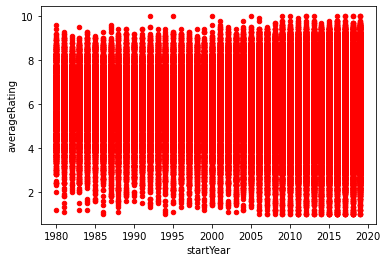

In [48]:
rated.plot(x="startYear", y="averageRating", kind="scatter", color="r")

In [49]:
rated = rated.groupby("startYear").mean()

In [50]:
final = rated.head(52)

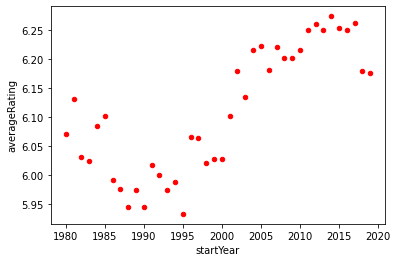

In [51]:
final = pd.DataFrame(final).reset_index()
final.plot(x="startYear", y="averageRating", kind="scatter", color="r")

In [52]:
final.to_csv("Average Movie Ratings.csv")

# Visualization

Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the consumer_sent graph
					-Problems:
						-Merged column shows data from 1990, but we want it from 1980
						-GDP_per_capita has larger with respect to unemployment_rate and consumer sentiment. Thus, it needs to be plotted in a different graph
						-I cannot merge the df from box_office_qrt with data_qrt because on “Date” because the the quarters are measured differently
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
		2-How does it shift the respective market shares of different genres?
		3-Do other externa factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.
		4-Consumer confidence increased. *Key indicator to evaluate*


### Influence of economic variables in the SUPPLY side of the film industry





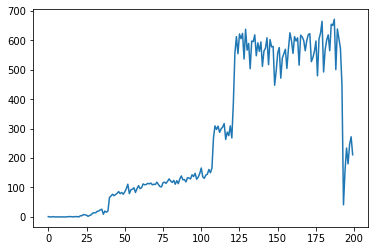

In [53]:
plt.plot(box_office_qrt.Releases)

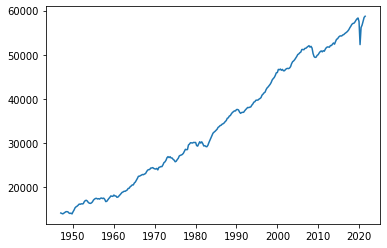

In [54]:
plt.plot(gdp_capita.Date, gdp_capita.gdp_per_capita)

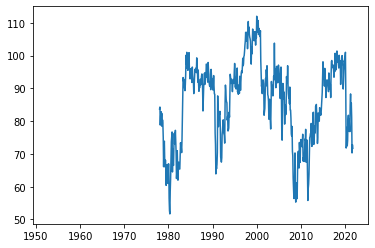

In [55]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [56]:
data_qrt.head(10)

,Date,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
0,1990-01-01,NaN,5.300000,91.266667,9364.259,37617.0,0.62198,11.649150,110,1.479302e+09
1,1990-04-01,NaN,5.333333,90.933333,9398.243,37636.0,0.62764,11.600660,103,1.709974e+09
2,1990-07-01,1.947705,5.700000,79.133333,9404.494,37529.0,0.63562,11.583131,102,2.047944e+09
3,1990-10-01,2.070536,6.133333,65.133333,9318.876,37056.0,0.64402,11.604449,116,1.602071e+09
4,1991-01-01,1.706441,6.600000,74.966667,9275.276,36769.0,0.64740,11.578032,118,1.806037e+09
5,1991-04-01,1.705381,6.833333,80.733333,9347.597,36938.0,0.65092,11.434237,114,1.443730e+09
6,1991-07-01,1.688488,6.866667,82.633333,9394.834,36993.0,0.65533,11.318681,121,1.870961e+09
7,1991-10-01,1.647881,7.100000,71.866667,9427.581,36995.0,0.66008,11.117333,129,1.516476e+09
8,1992-01-01,1.525923,7.366667,70.766667,9540.444,37328.0,0.66421,10.855581,122,1.629860e+09
9,1992-04-01,1.647074,7.600000,78.933333,9643.893,37607.0,0.66862,10.680886,117,1.683190e+09


In [57]:
# plt.plot(data_qrt.Date, data_qrt.UNRATE, data_qrt.Date)

In [58]:
box_office_qrt_Datex = box_office_qrt.set_index('Date')
box_office_qrt_Datex.head()

,Releases,gross
Date,,
1972-01-01,1,133698921
1972-04-01,0,0
1972-07-01,0,0
1972-10-01,1,84563118
1973-01-01,0,0


In [59]:
box_office_qrt_Datex_pct = box_office_qrt_Datex.pct_change()
box_office_qrt_Datex_pct.head()

,Releases,gross
Date,,
1972-01-01,NaN,NaN
1972-04-01,-1.0,-1.0
1972-07-01,NaN,NaN
1972-10-01,inf,inf
1973-01-01,-1.0,-1.0


In [60]:
# supply = data_qrt.merge(box_office_qrt_reset, on="Date", how="outer")
'''
It returns an error because thee quarter dates are different
''' 

'\nIt returns an error because thee quarter dates are different\n'

In [61]:
data_qrt_Datex = data_qrt.set_index('Date')
data_qrt_Datex_pct = data_qrt_Datex.pct_change()
data_qrt_Datex_pct.head()

,gas_price,UNRATE,consum_sent,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,NaN,0.006289,-0.003652,0.003629,0.000505,0.009100,-0.004163,-0.063636,0.155933
1990-07-01,NaN,0.068750,-0.129765,0.000665,-0.002843,0.012714,-0.001511,-0.009709,0.197647
1990-10-01,0.063065,0.076023,-0.176917,-0.009104,-0.012604,0.013215,0.001840,0.137255,-0.217717
1991-01-01,-0.175846,0.076087,0.150972,-0.004679,-0.007745,0.005248,-0.002276,0.017241,0.127314


In [62]:
%matplotlib inline

In [63]:
import matplotlib.pylab as plt

In [64]:
# read the recession data in data
from google.colab import files
uploaded = files.upload()

Saving USREC.csv to USREC.csv


(0.58, 0.65)

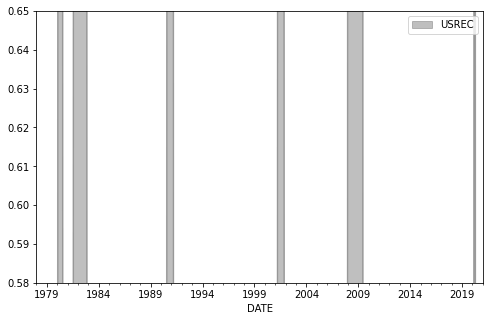

In [65]:
import io
us_rec = pd.read_csv(io.BytesIO(uploaded['USREC.csv']))

# make sure date columns are actual dates
us_rec["DATE"] = pd.to_datetime(us_rec["DATE"])
import matplotlib.pyplot as plt

# create plot (practice command)
fig, ax = plt.subplots()
us_rec.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="gray")
plt.xlim("1978-01-01", "2021-01-01")
plt.ylim(0.58, 0.65)

See below thar there are little differences in between the group of plots

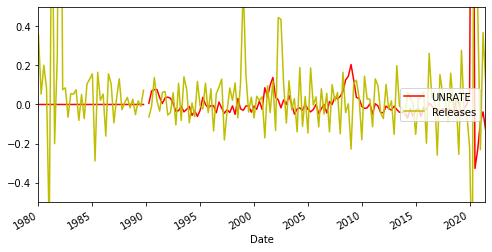

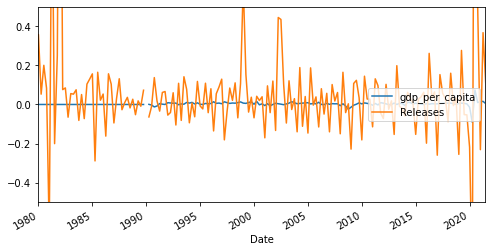

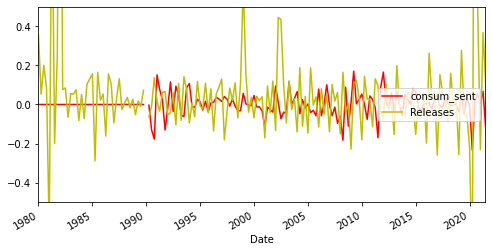

In [75]:
# 0-Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex_pct[['UNRATE', 'Releases']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_qrt_Datex_pct[['gdp_per_capita', 'Releases']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_qrt_Datex_pct[['consum_sent', 'Releases']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

plt.show()

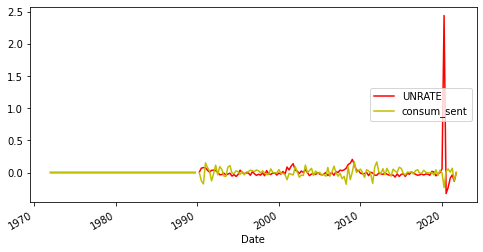

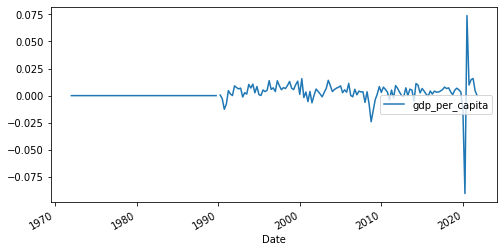

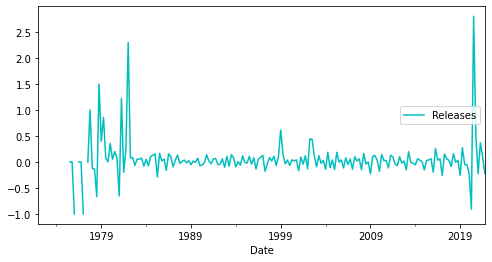

In [66]:
# 1-Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex_pct[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex_pct[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})

box_office_qrt_Datex_pct[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})

plt.show()

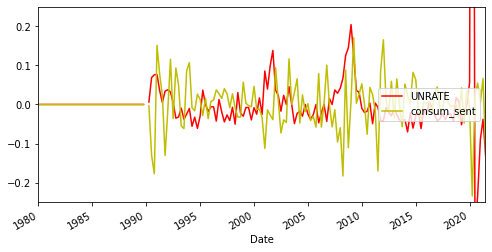

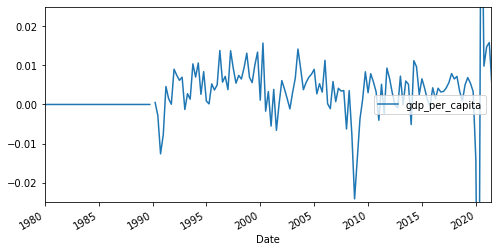

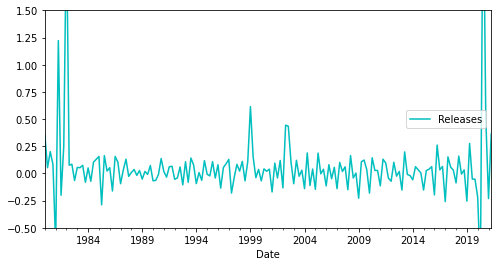

In [67]:
# 2-Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex_pct[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.25, 0.25)

data_qrt_Datex_pct[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.025, 0.025)

box_office_qrt_Datex_pct[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 1.5)

plt.show()

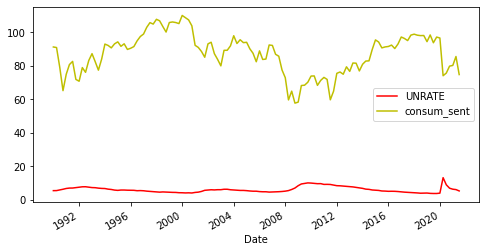

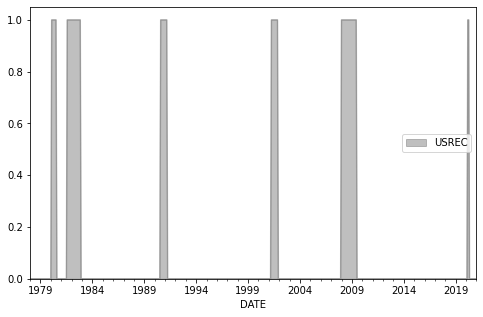

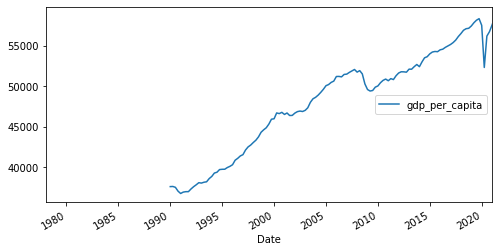

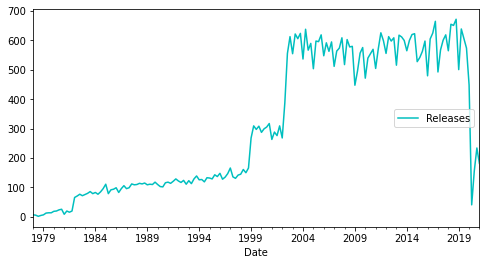

In [68]:
# 3-Plot for the econoomic conditions on the y-axis
data_qrt_Datex[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
fig, ax = plt.subplots()
us_rec.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="gray")
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})


box_office_qrt_Datex[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

plt.show()

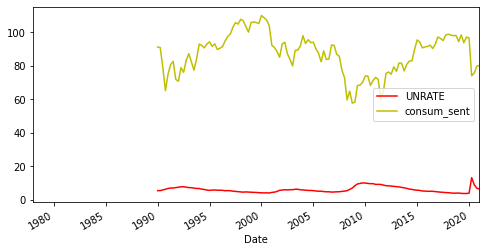

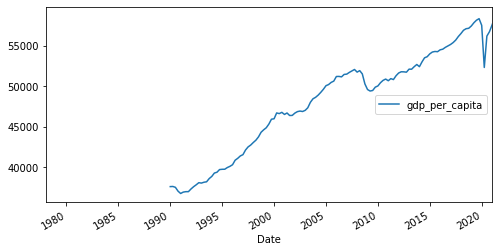

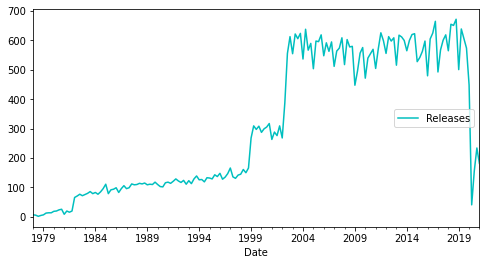

In [69]:
# 4-Plot for the econoomic conditions on the y-axis
data_qrt_Datex[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

box_office_qrt_Datex[['Releases']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

plt.show()

### Influence of economic variables in the DEMAND side of the film industry


The variable for cumulative revenue is "gross".
I still need to add the recession bars.

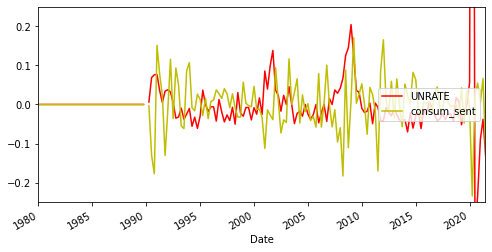

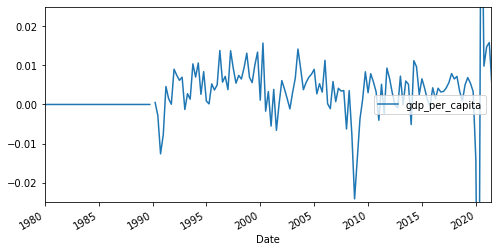

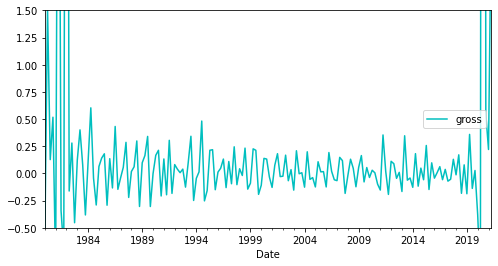

In [70]:
# 1-Plot for the econoomic conditions with percentage change on the y-axis
data_qrt_Datex_pct[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.25, 0.25)

data_qrt_Datex_pct[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.025, 0.025)

box_office_qrt_Datex_pct[['gross']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 1.5)

plt.show()

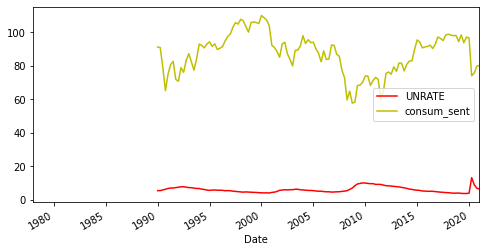

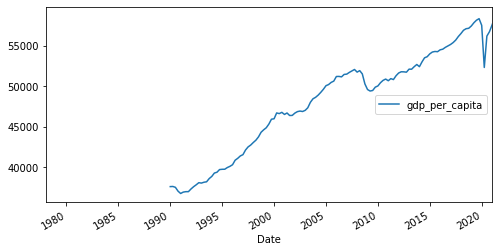

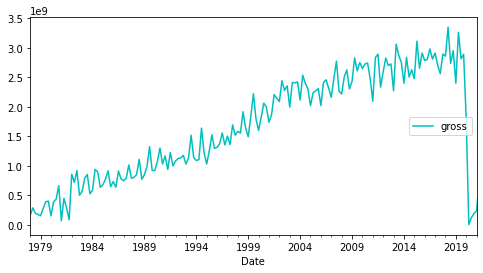

In [71]:
# 2-Plot for the economic conditions on the y-axis
data_qrt_Datex[['UNRATE', 'consum_sent']].plot(color = ('r','y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

data_qrt_Datex[['gdp_per_capita']].plot(figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

box_office_qrt_Datex[['gross']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc = 5, prop = {'size': 10})

plt.show()